# Filter Bank Common Spatial Pattern
Attempt at implementing filter-bank common spatial filter (FBCSP) on BCI Competition IV 2a Dataset
  
**References:**   

[1] Kai Keng Ang, Zheng Yang Chin, Haihong Zhang and Cuntai Guan, "Filter Bank Common Spatial Pattern (FBCSP) in Brain-Computer Interface," 2008 IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), Hong Kong, 2008, pp. 2390-2397, doi: 10.1109/IJCNN.2008.4634130.    
[2] Ang, K. K., Chin, Z. Y., Wang, C., Guan, C., & Zhang, H. (2012). Filter Bank Common Spatial Pattern Algorithm on BCI Competition IV Datasets 2a and 2b. Frontiers in Neuroscience, 6. doi: 10.3389/fnins.2012.00039

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# BCI Competition IV Dataset 2a (.npz data)
Information Given in Documentation

From the documentation it is known that:
* 25 electrodes are used, first 22 are EEG, last 3 are EOG
* Sampling frequency (fs) is 250Hz
* 9 subjects
* 9 run (run 1-3 are for eye movement, run 4-9 is MI)  
  

**-- Time Duration--**  
1 trials                          = 7-8s  
1 run              = 48 trials    = 336-384s  
1 session = 6 runs = 288 trials   = 2016-2304s

About the recording of eye movement
* run 1 => 2 mins with eyes open
* run 2 => 1 min with eyes closed
* run 3 => 1 min with eye movements

![timing-scheme-paradigm.png](./img/timing-scheme-paradigm.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Loading dataset

In [3]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
# mod_data will contain modified original data
ori_data = dict()
mod_data = dict()

In [4]:
# Function to count subject
def subject_counter(i):
    return 'subject0{}'.format(i)

In [5]:
# Path manipulation if running in dev container
if os.getcwd() == '/':
    print("Running the notebook it inside dev container..")
    base_dir = os.environ["DOCKER_WORKDIR"]
else:
    print("Running the notebook locally..")
    base_dir = os.getcwd()

Running the notebook locally..


In [6]:
# Load the training data of all subjects

# Iter over all data path then store them in sub0X variable
for i in range(1, ns):
    data_path = os.path.join(base_dir, '/content/drive/MyDrive/DL Assignments/PROJECT/SVM/datasets/A{:02d}T.npz'.format(i))
    subject = 'subject{:02d}'.format(i)

    # Load EEG data from datapath and store into subj0X variabel then store into data dictionary
    ori_data[subject] = np.load(data_path)

In [7]:
# Peek into ori_data type and its keys
print(type(ori_data['subject01']))
print(ori_data['subject01'].files)

<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


In [8]:
ori_data['subject01']['artifacts'].ravel()[20:50]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)

Explanation regarding contents of the keys inside each subject data:
* **s**: 's' contains continuous time-series recorded EEG signals are, shape of M x N array. Size may vary between subjects but N is fixed to 25, indicates 25 electrodes with 22 first EEG and 3 last EOG
* **etype**: 'etyp' stands for event type which indicate event occurence, event code will be describe in subsequent table
* **epos**: 'epos' stands for event position, denoting corresponding event begins at n-th sample at **'s'**
* **edur**: 'edur' stands for event duration, denoting duration of corresponding event
* **artifacts**: size of 288 x 1, 288 comes form 6 x 48, 6 runs where @run has 48 trials, @class has 12 trials

In [9]:
# ori_data will contain original data that is the raw file
# mod_data will contain modified original data

# Initialize 'subject0x' dict inside mod_data
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj] = {}

In [10]:
# Peek into different shape of recorded data/'s' between subjects
print('Sample\tElectrodes')
for i in range(1, ns):
    subj_temp = subject_counter(i)
    print(ori_data[subj_temp]['s'].shape)

Sample	Electrodes
(672528, 25)
(677169, 25)
(660530, 25)
(600915, 25)
(686120, 25)
(678980, 25)
(681071, 25)
(675270, 25)
(673328, 25)


In [11]:
# First extract the sample data from ori_data into mod_data
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = ori_data[subj]['s']

In [12]:
# Visualizing sample_data inside subject01
# You can see that it has 25 electrodes stored in columns
pd.DataFrame(mod_data['subject01']['raw_EEG']).head()

0          1          2          3          4          5   \
0 -21.142578 -23.681641 -21.484375 -25.146484 -25.732422 -27.929688   
1 -21.923828 -23.925781 -24.316406 -25.341797 -26.074219 -25.244141   
2 -15.625000 -19.726562 -18.847656 -21.582031 -20.751953 -21.728516   
3 -16.699219 -13.720703 -20.361328 -20.849609 -24.169922 -22.021484   
4 -19.335938 -17.626953 -20.410156 -26.464844 -27.392578 -29.882812   

          6          7          8          9   ...         15         16  \
0 -14.550781 -22.509766 -25.439453 -28.710938  ... -30.615234 -29.638672   
1 -16.064453 -22.753906 -28.320312 -29.248047  ... -31.054688 -30.712891   
2 -12.451172 -20.410156 -23.730469 -25.927734  ... -28.759766 -28.417969   
3 -10.986328 -16.357422 -25.585938 -24.951172  ... -27.783203 -28.857422   
4  -9.277344 -18.359375 -24.609375 -30.517578  ... -31.884766 -33.740234   

          17         18         19         20         21         22  \
0 -26.660156 -20.947266 -25.439453 -24.902344 -19.677734  31.738281   
1 -26.123047 -22.998047 -27.099609 -26.367188 -23.339844  22.460938   
2 -24.462891 -21.386719 -25.097656 -24.267578 -21.484375  33.691406   
3 -25.537109 -19.335938 -24.316406 -24.511719 -17.919922  41.992188   
4 -32.666016 -18.554688 -26.611328 -28.466797 -18.408203  37.109375   

          23         24  
0 -13.671875 -43.945312  
1 -13.183594 -40.527344  
2  -8.300781 -38.574219  
3  -7.324219 -38.574219  
4 -15.136719 -49.804688  

[5 rows x 25 columns]

# Preprocessing

In [13]:
# Removing last three EOG electrode using np.delete, store data as EEG_only to each subject dict
for i in range(1, ns):
    subj = subject_counter(i)
    mod_data[subj]['raw_EEG'] = np.delete(mod_data[subj]['raw_EEG'], np.s_[22:], 1)

## Bandpass Filtering
The first stage employing a filter bank is to decompose EEG into multiple frequency pass band, using causal Chebysev Type II filter/ Butterworth Filter.  
A total of 9 band-pass filters are used, namely, 4-8, 8-12, ... 36-40 Hz  
These frequency ranges are used because they yielf a stable frequency response and cover range of 4-40 Hz

In [14]:
# Band pass filter with butterworth filter
from scipy.signal import butter, lfilter
from scipy.signal import freqz

In [15]:
def butter_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b,a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal, axis=-1)

    return y

### Practice
Create arbitrary signal and using butterworth signal as band-pass filter

In [17]:
# INPUT
# sampling frequency
fs = 500

# time
t = np.arange(0, 5, 1/fs)

# Three signals with various freq
x1 = np.sin(2 * np.pi * 6 * t)
x2 = np.sin(2 * np.pi * 7 * t)
x3 = np.sin(2 * np.pi * 50 * t)
x = x1 + x2 + x3

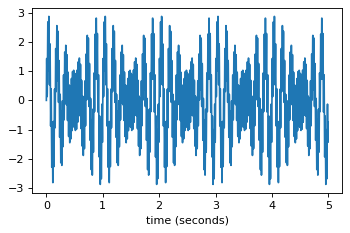

In [18]:
# Plot input
plt.figure(figsize=(5, 3), dpi=80)
plt.clf()
plt.plot(t, x)
plt.xlabel('time (seconds)')
plt.show()

In [19]:
# OUTPUT
lowcut = 4
highcut = 8
y= butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

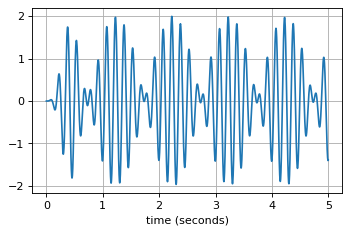

In [20]:
# Plot output
plt.figure(figsize=(5, 3), dpi=80)
plt.clf()
plt.plot(t, y, label='Filtered signal (%g Hz)' %fs)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.show()

### Filtering EEG signal with Butterworth Band-pass
Following the steps mentioned in [1], there will be 8 band-pass filter with bandwidth of:
1. 4-8Hz
2. 8-12Hz
3. 12-16Hz
4. 16-20Hz
5. 20-24Hz
6. 24-28Hz
7. 28-32Hz
8. 32-36Hz
9. 36-40Hz

*Note*   
Apply filter to the time-series axis, thus set 'raw_EEG' inside each subject to shape of N x T (i.e. electrodes x samples)

In [21]:
# Transpose all 'raw_EEG' data
for i in range(1, ns):
    subj = subject_counter(i)

    while mod_data[subj]['raw_EEG'].shape[0] != 22:
        mod_data[subj]['raw_EEG'] = mod_data[subj]['raw_EEG'].T

    print(mod_data[subj]['raw_EEG'].shape)

(22, 672528)
(22, 677169)
(22, 660530)
(22, 600915)
(22, 686120)
(22, 678980)
(22, 681071)
(22, 675270)
(22, 673328)


In [22]:
# Create function that could bandpass filtered one subject
def butter_bandpass_one_subject(data, subj, lowcut, highcut, fs, interval=None):
    print('Processing ', subj)

    # Create new key 'EEG_filtered' to store filtered EEG of each subject
    data[subj]['EEG_filtered'] = {}

    # Current raw EEG
    temp_raw_EEG = data[subj]['raw_EEG']

    if interval is not None:
        startband = np.arange(lowcut, highcut, step = interval)

        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start+interval)

            print('Filtering through {} Hz band'.format(band))
            # Bandpass filtering
            data[subj]['EEG_filtered'][band] = {}
            data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, start, start+interval, fs)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        data[subj]['EEG_filtered'][band]['EEG_all'] = butter_bandpass_filter(temp_raw_EEG, lowcut, highcut, fs)

In [23]:
# Bandpass filtering all subject
lowcut=4
highcut=40
fs = 250

# Iterate over all subjects
for i in range(1, 4):
    subj = subject_counter(i)
    butter_bandpass_one_subject(mod_data, subj, lowcut, highcut, fs, interval=4)
    print('')

Processing  subject01
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band
Filtering through 32_36 Hz band
Filtering through 36_40 Hz band

Processing  subject02
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band
Filtering through 32_36 Hz band
Filtering through 36_40 Hz band

Processing  subject03
Filtering through 04_08 Hz band
Filtering through 08_12 Hz band
Filtering through 12_16 Hz band
Filtering through 16_20 Hz band
Filtering through 20_24 Hz band
Filtering through 24_28 Hz band
Filtering through 28_32 Hz band
Filtering through 32_36 Hz band
Filtering through 36_40 Hz band



## Taking EEG data corresponds to left and right class
This work will only clasify two class, left and right hand, meanwhile the data contains four class,  
thus the goal here is to make band-filtered EEG left and right of each class of shape T x C x N, where  
T = trial, C = channel, N = sample

In [24]:
# First take the position of left and right class
left_class_code = 769
right_class_code = 770

for i in range(1, ns):
    subj = subject_counter(i)

    mod_data[subj]['left_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == left_class_code]
    mod_data[subj]['right_pos'] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == right_class_code]

In [25]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class
start = 0.5
end = 3.5

# Please modify this range to add more subject
for i in range(1, 4):
    subj = subject_counter(i)
    print('Processing ', subj)
    # Temporary variable of left and right pos
    temp_pos_left = mod_data[subj]['left_pos']
    temp_pos_right = mod_data[subj]['right_pos']

    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_EEG_all = mod_data[subj]['EEG_filtered'][band]['EEG_all']
        temp_EEG_left = []
        temp_EEG_right = []

        # LEFT
        for j in range(len(temp_pos_left)):
            temp_EEG_left.append(temp_EEG_all[:, temp_pos_left[j] + int(start*fs) : temp_pos_left[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_left'] = np.array(temp_EEG_left)

        # RIGHT
        for j in range(len(temp_pos_right)):
            temp_EEG_right.append(temp_EEG_all[:, temp_pos_right[j] + int(start*fs) : temp_pos_right[j] + int(end*fs)])
        mod_data[subj]['EEG_filtered'][band]['EEG_right'] = np.array(temp_EEG_right)

Processing  subject01
Processing  subject02
Processing  subject03


# Train/Test Data Split

In [26]:
def split_EEG_one_class(EEG_one_class, percent_train=0.8):
    '''
    split_EEG_one_class will receive EEG data of one class, with size of T x N x M, where
    T = number of trial
    N = number of electrodes
    M = sample number

    INPUT:
    EEG_data_one_class: the data of one class of EEG data

    percent_train: allocation percentage of training data, default is 0.8

    OUTPUT:
    EEG_train: EEG data for training

    EEG_test: EEG data for test

    Both have type of np.arrray dimension of T x M x N
    '''

    # Number of all trials
    n = EEG_one_class.shape[0]

    n_tr = round(n*percent_train)
    n_te = n - n_tr

    EEG_train = EEG_one_class[:n_tr]
    EEG_test = EEG_one_class[n_tr:n_tr+n_te]

    return EEG_train, EEG_test

In [27]:
# Iterate over all subjects
for i in range(1, 4):

    subj = subject_counter(i)

    # Iterate over all bands
    for band in mod_data[subj]['EEG_filtered'].keys():

        # Temporary variable for left and right class of each band
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right']

        # Temporary variable to access each band
        temp_filt = mod_data[subj]['EEG_filtered'][band]

        temp_filt['EEG_left_train'], temp_filt['EEG_left_test'] = split_EEG_one_class(temp_EEG_left, 0.8)
        temp_filt['EEG_right_train'], temp_filt['EEG_right_test'] = split_EEG_one_class(temp_EEG_right, 0.8)

In [28]:
mod_data['subject01']['EEG_filtered']['04_08'].keys()

dict_keys(['EEG_all', 'EEG_left', 'EEG_right', 'EEG_left_train', 'EEG_left_test', 'EEG_right_train', 'EEG_right_test'])

# CSP
This step will perform CSP on each band of each subject

In [29]:
# For all subject create new keys to store all result in CSP step
for i in range(1, ns):
    subj = subject_counter(i)

    mod_data[subj]['CSP'] = {}

## Covariance and Composite Covariance

In [30]:
def compute_cov(EEG_data):
    '''
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    '''
    cov = []
    for i in range(EEG_data.shape[0]):
        cov.append(EEG_data[i]@EEG_data[i].T/np.trace(EEG_data[i]@EEG_data[i].T))

    cov = np.mean(np.array(cov), 0)

    return cov

In [31]:
# Iterate over all subjects
for i in range(1, 4):

    subj = subject_counter(i)

    # Iterate over all bands
    for band in mod_data[subj]['EEG_filtered'].keys():

        # New key to store result
        temp_band = mod_data[subj]['CSP'][band] = {}

        # Compute left and right covariance
        # LEFT
        temp_band['cov_left'] = compute_cov(mod_data[subj]['EEG_filtered'][band]['EEG_left_train'])

        # RIGHT
        temp_band['cov_right'] = compute_cov(mod_data[subj]['EEG_filtered'][band]['EEG_right_train'])

        # Add covariance of left and right class as composite covariance
        temp_band['cov_comp'] = temp_band['cov_left'] + temp_band['cov_right']

In [32]:
temp1 = mod_data['subject03']['CSP']['04_08']['cov_left']
temp2 = mod_data['subject03']['CSP']['04_08']['cov_right']
temp3 = mod_data['subject03']['CSP']['04_08']['cov_comp']

## White Matrix (P)

In [33]:
# Create new keys for result in whitening step
for i in range(1, 4):
    subj = subject_counter(i)

    for band in mod_data[subj]['EEG_filtered'].keys():
        mod_data[subj]['CSP'][band]['whitening'] = {}

In [34]:
from scipy.linalg import sqrtm
from scipy.linalg import inv

In [35]:
def decompose_cov(avg_cov):
    '''
    This function will decompose average covariance matrix of one class of each subject into
    eigenvalues denoted by lambda and eigenvector denoted by V
    Both will be in descending order

    Parameter:
    avgCov = the averaged covariance of one class

    Return:
    λ_dsc and V_dsc, i.e. eigenvalues and eigenvector in descending order

    '''
    λ, V = np.linalg.eig(avg_cov)
    λ_dsc = np.sort(λ)[::-1] # Sort eigenvalue descending order, default is ascending order sort
    idx_dsc = np.argsort(λ)[::-1] # Find index in descending order
    V_dsc = V[:, idx_dsc] # Sort eigenvectors descending order
    λ_dsc = np.diag(λ_dsc) # Diagonalize λ_dsc

    return λ_dsc, V_dsc

In [36]:
def white_matrix(λ_dsc, V_dsc):
    '''
    '''
    λ_dsc_sqr = sqrtm(inv(λ_dsc))
    P = (λ_dsc_sqr)@(V_dsc.T)

    return P

In [37]:
# Iterate over all subject compute whitening matrix
for i in range(1, 4):
    subj = subject_counter(i)

    for band in mod_data[subj]['EEG_filtered'].keys():

        temp_whitening = mod_data[subj]['CSP'][band]['whitening']

        temp_cov = mod_data[subj]['CSP'][band]['cov_comp']

        # Decomposing composite covariance into eigenvector and eigenvalue
        temp_whitening['eigval'], temp_whitening['eigvec'] = decompose_cov(temp_cov)

        # White matrix
        temp_whitening['P'] = white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])

## Common Eigenvec from Sl and Sr
In this step the Sl and Sr will not be stored, will only be used to compute each eigenvector

In [38]:
# Create new keys for result in whitening step
for i in range(1, 4):
    subj = subject_counter(i)

    for band in mod_data[subj]['EEG_filtered'].keys():
        mod_data[subj]['CSP'][band]['S_left'] = {}
        mod_data[subj]['CSP'][band]['S_right'] = {}

In [39]:
def compute_S(avg_Cov, white):
    '''
    This function will compute S matrix, S = P * C * P.T

    INPUT:
    avg_Cov: averaged covariance of one class, dimension N x N, where N is number of electrodes
    white: the whitening transformation matrix

    OUTPUT:
    S
    '''
    S = white@avg_Cov@white.T

    return S

In [40]:
def decompose_S(S_one_class, order='descending'):
    '''
    This function will decompose the S matrix of one class to get the eigen vector
    Both eigenvector will be the same but in opposite order

    i.e the highest eigenvector in S left will be equal to lowest eigenvector in S right matrix
    '''
    # Decompose S
    λ, B = np.linalg.eig(S_one_class)

    # Sort eigenvalues either descending or ascending
    if order == 'ascending':
        idx = λ.argsort() # Use this index to sort eigenvector smallest -> largest
    elif order == 'descending':
        idx = λ.argsort()[::-1] # Use this index to sort eigenvector largest -> smallest
    else:
        print('Wrong order input')

    λ = λ[idx]
    B = B[:, idx]

    return B, λ

In [41]:
# Iterate over all subjects
for i in range(1, 4):
    subj = subject_counter(i)

    for band in mod_data[subj]['EEG_filtered'].keys():
        # Where to access data
        temp_P = mod_data[subj]['CSP'][band]['whitening']['P']
        Cl = mod_data[subj]['CSP'][band]['cov_left']
        Cr = mod_data[subj]['CSP'][band]['cov_right']

        # Where to store result
        temp_Sl = mod_data[subj]['CSP'][band]['S_left']
        temp_Sr = mod_data[subj]['CSP'][band]['S_right']

        # LEFT
        Sl = compute_S(Cl, temp_P)
        temp_Sl['eigvec'], temp_Sl['eigval'] = decompose_S(Sl, 'descending')

        # RIGHT
        Sr = compute_S(Cr, temp_P)
        temp_Sr['eigvec'], temp_Sr['eigval'] = decompose_S(Sr, 'ascending')

In [42]:
# Checking eigenvalues
temp1 = mod_data['subject02']['CSP'][band]['S_left']['eigval']
temp2 = mod_data['subject02']['CSP'][band]['S_right']['eigval']

In [43]:
temp1 + temp2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

## Spatial Filter (W)
Will compute the spatial filter of each subject of each band

In [44]:
def spatial_filter(B, P):
    '''
    Will compute projection matrix using the following equation:
    W = B' @ P

    INPUT:
    B: the eigenvector either left or right class, choose one, size N x N, N is number of electrodes
    P: white matrix in size of N x N

    OUTPUT:
    W spatial filter to filter EEG
    '''

    return (B.T@P)

In [45]:
# Iterate over all subject
for i in range(1, 4):
    subj = subject_counter(i)

    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_eigvec = mod_data[subj]['CSP'][band]['S_left']['eigvec']
        temp_P = mod_data[subj]['CSP'][band]['whitening']['P']

        mod_data[subj]['CSP'][band]['W'] = spatial_filter(temp_eigvec, temp_P)

In [46]:
temp = mod_data['subject01']['CSP'][band]['W']

In [47]:
pd.DataFrame(temp).head()

0         1         2          3         4         5         6   \
0 -2.067070 -1.795517  0.674657  -0.600279 -0.531707  0.051805 -3.608875   
1  3.211127  3.787021  2.845078 -10.448529  5.912025  4.520385 -0.201067   
2  0.552975 -2.063569  8.071851  -6.107381 -4.715290 -1.655538  0.547787   
3  0.916960  3.301811 -1.701912  -7.291251  8.600569 -1.170277  4.354018   
4  4.530817 -4.483058  0.696202  -1.169662 -9.148161  1.393574 -1.243655   

          7         8          9   ...        12        13         14  \
0  13.728214  2.541841 -10.669084  ... -0.425582 -2.234119  -5.843472   
1  -3.131450  2.107776   3.001354  ...  0.554703 -4.511235  -3.368763   
2   2.839704 -4.037424  -0.650903  ... -1.897266 -5.762726   3.309403   
3  -4.512817 -8.844287  11.326760  ... -3.514433 -1.926884   8.258898   
4   7.320753 -6.916603  12.311359  ...  2.384958 -3.037356  13.978873   

          15         16         17        18         19        20        21  
0  -1.293616  10.676630 -10.946518  5.049042 -13.617283  8.553094  1.837880  
1   9.981609  -0.044675   1.422170  6.427704  -6.862532 -3.545508  2.428964  
2   7.634191 -16.817554   9.931688  1.589882  -2.605074 -5.322589  3.264397  
3  -7.649393   5.699625   7.526022  4.220684   0.045373 -3.332242 -2.371642  
4 -14.547555   7.692809  -3.559007 -2.550236  -0.107876 -6.187102  4.079949  

[5 rows x 22 columns]

# Feature Vector Train

In [48]:
# Create new keys for trainning and test feature vector
for i in range(1, 4):
    subj = subject_counter(i)
    mod_data[subj]['train'] = {}
    mod_data[subj]['test'] = {}

    for band in mod_data[subj]['EEG_filtered'].keys():
        mod_data[subj]['train'][band] = {}
        mod_data[subj]['test'][band] = {}

In [49]:
# Select number of filter
m = 2

In [50]:
def compute_Z(W, E, m):
    '''
    Will compute the Z
    Z = W @ E,

    E is in the shape of N x M, N is number of electrodes, M is sample
    In application, E has nth trial, so there will be n numbers of Z

    Z, in each trial will have dimension of m x M,
    where m is the first and last m rows of W, corresponds to smallest and largest eigenvalues
    '''
    Z = []

    W = np.delete(W, np.s_[m:-m:], 0)

    for i in range(E.shape[0]):
        Z.append(W @ E[i])

    return np.array(Z)

In [52]:
def feat_vector(Z):
    '''
    Will compute the feature vector of Z matrix

    INPUT:
    Z : projected EEG shape of T x N x S

    OUTPUT:
    feat : feature vector shape of T x m

    T = trial
    N = channel
    S = sample
    m = number of filter
    '''

    feat = []

    for i in range(Z.shape[0]):
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)

        feat.append(np.log10(var/varsum))

    return np.array(feat)

In [53]:
mod_data['subject01']['CSP']['04_08'].keys()

dict_keys(['cov_left', 'cov_right', 'cov_comp', 'whitening', 'S_left', 'S_right', 'W'])

In [54]:
mod_data['subject01']['EEG_filtered'][band].keys()

dict_keys(['EEG_all', 'EEG_left', 'EEG_right', 'EEG_left_train', 'EEG_left_test', 'EEG_right_train', 'EEG_right_test'])

In [55]:
# Iterate over all subjects
for i in range(1, 4):
    subj = subject_counter(i)

    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_W = mod_data[subj]['CSP'][band]['W']
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left_train']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right_train']

        # LEFT
        mod_data[subj]['train'][band]['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
        mod_data[subj]['train'][band]['feat_left'] = feat_vector(mod_data[subj]['train'][band]['Z_left'])

        left_label = np.zeros([len(mod_data[subj]['train'][band]['feat_left']), 1])

        # RIGHT
        mod_data[subj]['train'][band]['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
        mod_data[subj]['train'][band]['feat_right'] = feat_vector(mod_data[subj]['train'][band]['Z_right'])

        right_label = np.ones([len(mod_data[subj]['train'][band]['feat_right']), 1])

        left  = np.c_[mod_data[subj]['train'][band]['feat_left'], left_label]
        right  = np.c_[mod_data[subj]['train'][band]['feat_right'], right_label]

        mod_data[subj]['train'][band]['feat_train'] = np.vstack([left, right])

        np.random.shuffle(mod_data[subj]['train'][band]['feat_train'])

## Merging Train Feature of All Bandwidth
Merging all feature of each bandpass horizontally  
This will result in an array with shape of T x (9 * 2m) without true label  
where m is the number of filter, and T is number of trials

In [56]:
mod_data['subject01']['train']['04_08']['feat_left'].shape

(58, 4)

In [57]:
# Iterate over all subjects
for i in range(1, 4):
    subj = subject_counter(i)

    feat_left_all = []
    feat_right_all = []

    for band in mod_data[subj]['EEG_filtered'].keys():
        # Access LEFT each band
        feat_left = mod_data[subj]['train'][band]['feat_left']

        feat_left_all.append(feat_left)

        # Access RIGHT each band
        feat_right = mod_data[subj]['train'][band]['feat_right']

        feat_right_all.append(feat_right)

    # MERGING (Need to find more efficient method)
    # LEFT
    merge_left = np.zeros(feat_left_all[0].shape)

    for i in feat_left_all:
        merge_left = np.concatenate([merge_left, i], axis=1)

    # Delete initial zeros
    merge_left = np.delete(merge_left, np.s_[:2*m], axis=1)

    # RIGHT
    merge_right = np.zeros(feat_right_all[0].shape)

    for i in feat_right_all:
        merge_right = np.concatenate([merge_right, i], axis=1)

    # Delete initial zeros
    merge_right = np.delete(merge_right, np.s_[:2*m], axis=1)

    # TRUE LABEL
    true_left = np.zeros([merge_left.shape[0], 1])
    true_right = np.ones([merge_right.shape[0], 1])

    # FEATURE + TRUE LABEL
    left = np.hstack([merge_left, true_left])
    right = np.hstack([merge_right, true_right])

    # MERGE LEFT AND RIGHT
    train_feat = np.vstack([left, right])

    np.random.shuffle(train_feat)

    mod_data[subj]['train']['all_band'] = train_feat

In [58]:
# Sanity check
assert (mod_data['subject01']['train']['all_band'].shape == (116, 9*2*m + 1))

## Mutual Based Information (MI) to Select Most Informative Band

In [59]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [60]:
for i in range(1, 4):
    subj = subject_counter(i)

    X_train = mod_data[subj]['train']['all_band'][:, :-1]
    y_train = mod_data[subj]['train']['all_band'][:, -1]

    # New dictionary to store result
    mod_data[subj]['train']['mutual'] = {}

    # Use mutual information to find 4 most informative feature
    select = SelectKBest(mutual_info_classif, k = 4).fit(X_train, y_train)
    mod_data[subj]['train']['mutual']['X'] = X_train[:, select.get_support()]
    mod_data[subj]['train']['mutual']['y'] = y_train

# Feature Vector Test

In [61]:
# Seed to fix randomization
np.random.seed(42)

# Iterate over all subjects
for i in range(1, 4):
    subj = subject_counter(i)

    for band in mod_data[subj]['EEG_filtered'].keys():
        temp_W = mod_data[subj]['CSP'][band]['W']
        temp_EEG_left = mod_data[subj]['EEG_filtered'][band]['EEG_left_test']
        temp_EEG_right = mod_data[subj]['EEG_filtered'][band]['EEG_right_test']

        # LEFT
        mod_data[subj]['test'][band]['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
        mod_data[subj]['test'][band]['feat_left'] = feat_vector(mod_data[subj]['test'][band]['Z_left'])

        left_label = np.zeros([len(mod_data[subj]['test'][band]['feat_left']), 1])

        # RIGHT
        mod_data[subj]['test'][band]['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
        mod_data[subj]['test'][band]['feat_right'] = feat_vector(mod_data[subj]['test'][band]['Z_right'])

        right_label = np.ones([len(mod_data[subj]['test'][band]['feat_right']), 1])

        # MERGING LEFT, RIGHT
        left  = np.c_[mod_data[subj]['test'][band]['feat_left'], left_label]
        right  = np.c_[mod_data[subj]['test'][band]['feat_right'], right_label]

        mod_data[subj]['test'][band]['feat_test'] = np.vstack([left, right])

        np.random.shuffle(mod_data[subj]['test'][band]['feat_test'])

## Merging Train Feature of All Bandwidth

In [62]:
# Iterate over all subjects
for i in range(1, 4):
    subj = subject_counter(i)

    feat_left_all = []
    feat_right_all = []

    for band in mod_data[subj]['EEG_filtered'].keys():
        # Access LEFT each band
        feat_left = mod_data[subj]['test'][band]['feat_left']

        feat_left_all.append(feat_left)

        # Access RIGHT each band
        feat_right = mod_data[subj]['test'][band]['feat_right']

        feat_right_all.append(feat_right)


    # MERGING (Need to find more efficient method)
    # LEFT
    merge_left = np.zeros(feat_left_all[0].shape)

    for i in feat_left_all:
        merge_left = np.concatenate([merge_left, i], axis=1)

    # Delete initial zeros
    merge_left = np.delete(merge_left, np.s_[:2*m], axis=1)

    # RIGHT
    merge_right = np.zeros(feat_right_all[0].shape)

    for i in feat_right_all:
        merge_right = np.concatenate([merge_right, i], axis=1)

    # Delete initial zeros
    merge_right = np.delete(merge_right, np.s_[:2*m], axis=1)

    # TRUE LABEL
    true_left = np.zeros([merge_left.shape[0], 1])
    true_right = np.ones([merge_right.shape[0], 1])

    # FEATURE + TRUE LABEL
    left = np.hstack([merge_left, true_left])
    right = np.hstack([merge_right, true_right])

    # MERGE LEFT AND RIGHT
    test_feat = np.vstack([left, right])

    np.random.shuffle(test_feat)

    mod_data[subj]['test']['all_band'] = test_feat

In [63]:
mod_data['subject01']['test']['all_band'].shape

(28, 37)

## Mutual Based Information (MI) to Select Most Informative Band

In [64]:
for i in range(1, 4):
    subj = subject_counter(i)

    X_test = mod_data[subj]['test']['all_band'][:, :-1]
    y_test = mod_data[subj]['test']['all_band'][:, -1]

    # New dictionary to store result
    mod_data[subj]['test']['mutual'] = {}

    # Use mutual information to find 4 most informative feature
    select = SelectKBest(mutual_info_classif, k = 4).fit(X_test, y_test)
    mod_data[subj]['test']['mutual']['X'] = X_test[:, select.get_support()]
    mod_data[subj]['test']['mutual']['y'] = y_test

# Classification

In [65]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [66]:
# Define model
model = SVC(gamma='scale')

In [67]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Evaluate Model Performance on Train Data

In [68]:
# Iterate over each subject
eval_acc = []
eval_std = []

for i in range(1, 4):
    subj = subject_counter(i)

    print('Processing for {}'.format(subj))
    X_train = mod_data[subj]['train']['mutual']['X']
    y_train = mod_data[subj]['train']['mutual']['y']

    eval_acc.append(cross_val_score(model, X_train, y_train, cv=5).mean()*100)
    eval_std.append(cross_val_score(model, X_train, y_train, cv=5).std()*100)

Processing for subject01
Processing for subject02
Processing for subject03


In [69]:
eval_acc

[92.31884057971014, 81.84782608695652, 97.42753623188406]

In [70]:
# Necessary variable to label x axis
subject=[]
for i in range(1, ns):
    subject.append(subject_counter(i))

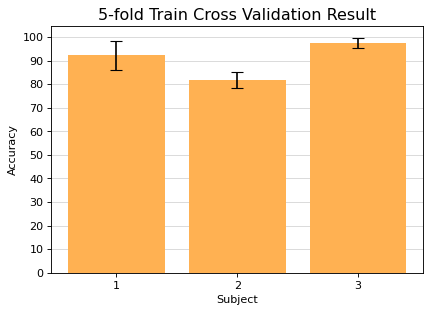

====== Accuracy for all subjects ======
Subject01 : 92.32 % +/- 6.18
Subject02 : 81.85 % +/- 3.43
Subject03 : 97.43 % +/- 2.10


In [71]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, 4), eval_acc, color="#ffb152", yerr=eval_std, capsize=5)
ax.set(xticks=np.arange(1, 4), xlabel='Subject',
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='5-fold Train Cross Validation Result')
ax.set_axisbelow(True)
plt.savefig('5fold_train_result.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("====== Accuracy for all subjects ======")
for i in range(3):
    print("Subject{:02d} : {:.2f} % +/- {:.2f}".format(i+1, eval_acc[i], eval_std[i]))

## Result on Test Data
Based on initial observation, svc model performed well on train data. Thus we will proceed to use the current model to evaluate on test data

In [72]:
# Blank list to store accuracy values
train_score = []
test_score = []

for i in range(1, 4):
    subj = subject_counter(i)

    # Prepare train and test data
    data_train = mod_data[subj]['train']['mutual']
    X_train = data_train['X']
    y_train = data_train['y']

    data_test = mod_data[subj]['test']['mutual']
    X_test = data_train['X']
    y_test = data_train['y']

    # Training the model + train accuracy
    model.fit(X_train, y_train)
    tr_score = model.score(X_train, y_train)*100
    te_score = model.score(X_test, y_test)*100

    train_score.append(tr_score)
    test_score.append(te_score)

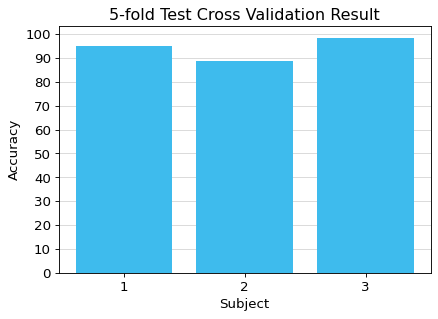

====== Test Accuracy for all subjects ======
Subject01 : 94.83 %
Subject02 : 88.79 %
Subject03 : 98.28 %


In [73]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.grid(axis='y', alpha=0.5)
ax.bar(np.arange(1, 4), test_score, color="#3ebbed")
ax.set(xticks=np.arange(1, 4), xlabel='Subject',
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='5-fold Test Cross Validation Result')
ax.set_axisbelow(True)
plt.savefig('5fold_test_result.jpg', bbox_inches='tight')
plt.show()

# Print each subject accuracy
print("====== Test Accuracy for all subjects ======")
for i in range(3):
    print("Subject{:02d} : {:.2f} %".format(i+1, test_score[i]))